In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow import keras

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

pd.set_option('display.max_columns', None)
# pd.set_option("display.max_rows", None)

In [3]:
!hostname

hippocampus.cslab.moravian.edu


Frame the Problem & Look At the Big Picture 
-------------------------------------------

1. Define the objective in business terms. 
    * The business objective is to predict the stock price for a specific ticker 7 days into the future.
2. How will your solution be used? 
    * The solution will be used to determine when to buy and/or sell stock(s). 
3. What are the current solutions/workarounds (if any)? 
    * There are other people/companies who have attempted to do this with varying levels of success. For many people, they trade stocks using technical analysis which means they intuitively learn trends using various signals (many of which are in the data set).
4. How should you frame this problem?
    * This problem is going to be framed as an offline regression (forecasting) model, but it should ideally be an online model so that it can constantly learn from new data when the stock market is open.
    * If we end up using AWS, then this model will be an online regression model.
    * Also multioutput regression because we are trying to predict for multiple stocks at the same time.
5. How should performance be measured?
    * Root mean squared error (RMSE). 
6. What would be the minimum performance needed to reach the business objective?
    * The minimum performance needed would, at the very least, correctly identify the directional trend of price (up or down), but it would additionally be heavily preferable if the prices/change in prices were as close to the true value as possible (minimum distance).
7. What are comparable problems?
    * We have not worked on any other comparable problems that also used time-series data, but there are AWS resources we can look into as well as read the chapter of the textbook on time-series data. 
8. Is human expertise available?
    * {Jeff, Google, StackOverFlow, GitHub CoPilot}
9. How would you solve this problem manually?
    * Ask WSB (lol… unless?)
    * In reality, I would only use a fraction of the indicators that are already provided in the data set (such as MACD, RSI, EMA, VWAP). These indicators are graphed as lines against the price of the stock prices and can be used to infer whether the stock price will move up or down.
10. List the assumptions you have made so far. Verify the assumptions if possible.
    * I am assuming that the data is historically accurate.
    * The types of trends identified for one company can also be applied to others, otherwise you would probably need a separate model for each company.
    * The data is only from 2010-Present, so there are no recessions in the data (except for the 2019 pandemic). So, the resulting model may not perform well in the event of economic downturn since most of the data takes place in a bull economy.

Get the Data 
----
1. List the data you need and how much you need 
    * We need historic stock data with lots of technical indicators (around 60 features) and other general indicators. At least a few thousand samples would be nice, but we luckily have over 34,000.
2. Find and document where you can get that data 
    * Our dataset was found on Kaggle Open Source: https://www.kaggle.com/datasets/nikhilkohli/us-stock-market-data-60-extracted-features (Links to an external site.)
3. Get access authorizations 
    * Free to use
4. Create a workspace (with enough storage space) 
    * This notebook / hippocampus
5. Get the data 
    * Done
6. Convert the data to a format you can easily manipulate (without changing the data itself) 
    * Done
7. Ensure sensitive information is deleted or protected (e.g. anonymized) 
    * N/A
8. Check the size and type of data (time series, geographical, ...) 
    * Time Series Data
9. Sample a test set, put it aside, and never look at it (no data snooping!)  
    * Done

In [4]:
# methods

def load_data():
    """
    Loads the data from the csv files and creates a column for ticker
    """
    data = None
    for root, _, files in os.walk('./data'):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file))
                # make the date the index
                df.set_index('Date', inplace=True)
                # prefix the columns with the ticker
                ticker = file.split('.')[0]
                df = df.add_prefix(ticker + '_')
                if data is None:
                    data = df
                else:
                    # merge the dataframes
                    data = data.merge(df, how='outer', left_index=True, right_index=True)
    data = close_to_percent_change(data, ['Close(t)'])
    # reset indexes to standard indexes
    data.reset_index(inplace=True)
    data.drop(columns=['Date'], inplace=True)
    
    # drop any columns containing `checkpoint` in the name
    data.drop(columns=[col for col in data.columns if 'checkpoint' in col], inplace=True)

    return data

def close_to_percent_change(df, cols_like):
    """
    Calculates the percent change of the close price
    Requires the first sample to be dropped since its percent change cannot be calculated
    """
    cols = [col for col_like in cols_like for col in df.filter(like=col_like).columns]
    for col in cols:
        # replace the value in each sample with the percent change from the previous sample
        df[col] = df[col].pct_change()
        # drop the first sample since its percent change cannot be calculated
        df.drop(df.index[0], inplace=True)
    return df
                


In [5]:
data = load_data()

In [6]:
# create a training and test set
# training set with 80% of the data
train = data.iloc[:int(len(data) * 0.8)]
# test set with 20% of the data
validation = data.iloc[int(len(data) * 0.8): int(len(data) * 0.8) + 7]
test = data.iloc[int(len(data) * 0.8) + 7:]

Explore the data
----
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
    * Done
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
    * The only data that was not numeric was the name(ticker) of the stock, and the date, but those were either made part of the index or column names.
    * All remaining attributes are numeric.
    * Some are categorical, all time-related
    * The distributions of many of the attributes change from stock to stock, which is interesting, but also makes sense. It could be worth it to make transformations based on the averages, making the model well rounded, but it would introduce some level of error for each stock than if it was trained individually. 
3. For supervised learning tasks, identify the target attribute(s) 
    * Closing Price for each stock (or percentage change in price of the scaling reduces the ability of the model to predict prices)
4. Visualize the data 
    * Done Below
5. Study the correlations between attributes 
    * DayOfYear as mentioned above^
    * ROC, RSI, William%R and SD%K Are all very highly correlated with each other
    * STDS has a moderate negative correlation with most features
    MA's, EMA's, Upper Band and Lower Bound have very, very high correlations with open close high and low
        * MACD and MACD_EMA moderately correlated with all features mentioned above ^ 
    * Is_leap_year is interestingly moderately negatively correlated with open, high low, etc.
    Year is highly correlated (because of all data being from bull economy). May be worth dropping year.
6. Study how you would solve the problem manually 
    * To solve this problem manually, we would grab a few estimators, like RSI, MACD, Upper and Lower Bounds and some few others and attempt to make predictions using the general direction implied by the data. Determining the direction may be achieveable somewhat, but the amount by which it changes seems like it would not be very accurate. 
7. Identify the promising transformations you may want to apply 
    * Features such as *_S_Close(t-N), *_S_Open(t-1), *_QQQ(t-n), SnP(t-n), *_DJIA(t-n) should be dropped because they are historic data included in one sample. If included, would be lots of duplicate data.
    * *_Close_Forecast should also be dropped because it is the tomorrow's target, obviously do not want the y in the X.
    * Drop *_Date_col because the date is already the index.
    * After checking the correlation of the other time data, many can be removed. DayOfYear is perfectly correlated with month, so month could just be removed since DayOfYear conveys the same information.
    * Some companies, like Tesla, were not public during the beginning of this data set, so the data will have to be imputed
        * We do not wish to drop the samples because we would be missing out on lots of data. Alternatively, those companies could be dropped altogether, but it might be the model less diverse.
        * Actually, only two companies, FB and Tesla, are missing data, so we are just going to drop those columns.
    * We predict that a min-max scaler would be more suitable for the data since the stock prices can vary very much between stocks. (ex. AMZN in 1000s and MSFT at ~100)
        * It may be possible that this will result in the model being unable to accurately know the range that the stock falls in, so it may be worth it to go back and calculate change in stock close price rather than the price itself.
    * Consider dropping year since the market has been on a bull run for the entirety of the time the data covers.
    * Consider logging the QQQ cols, Open, EMA#. These make the overall distribtion more normal, but makes the two individual bimodal distributions skewered, so it may not be worth logging.
    * Could log Volume, STD5, ATR, though.
8. Identify extra data that would be useful (go back to “Get the Data”) 
    * This should be sufficient apart from the already assumed shortcomings of the data.
9. Document what you have learned 
    * There are groups of features that are almost perfectly correlated with each other.

In [8]:
train_copy = train.copy()

In [15]:
train_copy

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close(t),AMZN_Volume,AMZN_SD20,AMZN_Upper_Band,AMZN_Lower_Band,AMZN_S_Close(t-1),AMZN_S_Close(t-2),AMZN_S_Close(t-3),AMZN_S_Close(t-5),AMZN_S_Open(t-1),AMZN_MA5,AMZN_MA10,AMZN_MA20,AMZN_MA50,AMZN_MA200,AMZN_EMA10,AMZN_EMA20,AMZN_EMA50,AMZN_EMA100,AMZN_EMA200,AMZN_MACD,AMZN_MACD_EMA,AMZN_ATR,AMZN_ADX,AMZN_CCI,AMZN_ROC,AMZN_RSI,AMZN_William%R,AMZN_SO%K,AMZN_STD5,AMZN_ForceIndex1,AMZN_ForceIndex20,AMZN_Date_col,AMZN_Day,AMZN_DayofWeek,AMZN_DayofYear,AMZN_Week,AMZN_Is_month_end,AMZN_Is_month_start,AMZN_Is_quarter_end,AMZN_Is_quarter_start,AMZN_Is_year_end,AMZN_Is_year_start,AMZN_Is_leap_year,AMZN_Year,AMZN_Month,AMZN_QQQ_Close,AMZN_QQQ(t-1),AMZN_QQQ(t-2),AMZN_QQQ(t-5),AMZN_QQQ_MA10,AMZN_QQQ_MA20,AMZN_QQQ_MA50,AMZN_SnP_Close,AMZN_SnP(t-1)),AMZN_SnP(t-5),AMZN_DJIA_Close,AMZN_DJIA(t-1)),AMZN_DJIA(t-5),AMZN_Close_forcast,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close(t),MSFT_Volume,MSFT_SD20,MSFT_Upper_Band,MSFT_Lower_Band,MSFT_S_Close(t-1),MSFT_S_Close(t-2),MSFT_S_Close(t-3),MSFT_S_Close(t-5),MSFT_S_Open(t-1),MSFT_MA5,MSFT_MA10,MSFT_MA20,MSFT_MA50,MSFT_MA200,MSFT_EMA10,MSFT_EMA20,MSFT_EMA50,MSFT_EMA100,MSFT_EMA200,MSFT_MACD,MSFT_MACD_EMA,MSFT_ATR,MSFT_ADX,MSFT_CCI,MSFT_ROC,MSFT_RSI,MSFT_William%R,MSFT_SO%K,MSFT_STD5,MSFT_ForceIndex1,MSFT_ForceIndex20,MSFT_Date_col,MSFT_Day,MSFT_DayofWeek,MSFT_DayofYear,MSFT_Week,MSFT_Is_month_end,MSFT_Is_month_start,MSFT_Is_quarter_end,MSFT_Is_quarter_start,MSFT_Is_year_end,MSFT_Is_year_start,MSFT_Is_leap_year,MSFT_Year,MSFT_Month,MSFT_QQQ_Close,MSFT_QQQ(t-1),MSFT_QQQ(t-2),MSFT_QQQ(t-5),MSFT_QQQ_MA10,MSFT_QQQ_MA20,MSFT_QQQ_MA50,MSFT_SnP_Close,MSFT_SnP(t-1)),MSFT_SnP(t-5),MSFT_DJIA_Close,MSFT_DJIA(t-1)),MSFT_DJIA(t-5),MSFT_Close_forcast,FB_Open,FB_High,FB_Low,FB_Close(t),FB_Volume,FB_SD20,FB_Upper_Band,FB_Lower_Band,FB_S_Close(t-1),FB_S_Close(t-2),FB_S_Close(t-3),FB_S_Close(t-5),FB_S_Open(t-1),FB_MA5,FB_MA10,FB_MA20,FB_MA50,FB_MA200,FB_EMA10,FB_EMA20,FB_EMA50,FB_EMA100,FB_EMA200,FB_MACD,FB_MACD_EMA,FB_ATR,FB_ADX,FB_CCI,FB_ROC,FB_RSI,FB_William%R,FB_SO%K,FB_STD5,FB_ForceIndex1,FB_ForceIndex20,FB_Date_col,FB_Day,FB_DayofWeek,FB_DayofYear,FB_Week,FB_Is_month_end,FB_Is_month_start,FB_Is_quarter_end,FB_Is_quarter_start,FB_Is_year_end,FB_Is_year_start,FB_Is_leap_year,FB_Year,FB_Month,FB_QQQ_Close,FB_QQQ(t-1),FB_QQQ(t-2),FB_QQQ(t-5),FB_QQQ_MA10,FB_QQQ_MA20,FB_QQQ_MA50,FB_SnP_Close,FB_SnP(t-1)),FB_SnP(t-5),FB_DJIA_Close,FB_DJIA(t-1)),FB_DJIA(t-5),FB_Close_forcast,IBM_Open,IBM_High,IBM_Low,IBM_Close(t),IBM_Volume,IBM_SD20,IBM_Upper_Band,IBM_Lower_Band,IBM_S_Close(t-1),IBM_S_Close(t-2),IBM_S_Close(t-3),IBM_S_Close(t-5),IBM_S_Open(t-1),IBM_MA5,IBM_MA10,IBM_MA20,IBM_MA50,IBM_MA200,IBM_EMA10,IBM_EMA20,IBM_EMA50,IBM_EMA100,IBM_EMA200,IBM_MACD,IBM_MACD_EMA,IBM_ATR,IBM_ADX,IBM_CCI,IBM_ROC,IBM_RSI,IBM_William%R,IBM_SO%K,IBM_STD5,IBM_ForceIndex1,IBM_ForceIndex20,IBM_Date_col,IBM_Day,IBM_DayofWeek,IBM_DayofYear,IBM_Week,IBM_Is_month_end,IBM_Is_month_start,IBM_Is_quarter_end,IBM_Is_quarter_start,IBM_Is_year_end,IBM_Is_year_start,IBM_Is_leap_year,IBM_Year,IBM_Month,IBM_QQQ_Close,IBM_QQQ(t-1),IBM_QQQ(t-2),IBM_QQQ(t-5),IBM_QQQ_MA10,IBM_QQQ_MA20,IBM_QQQ_MA50,IBM_SnP_Close,IBM_SnP(t-1)),IBM_SnP(t-5),IBM_DJIA_Close,IBM_DJIA(t-1)),IBM_DJIA(t-5),IBM_Close_forcast,GS_Open,GS_High,GS_Low,GS_Close(t),GS_Volume,GS_SD20,GS_Upper_Band,GS_Lower_Band,GS_S_Close(t-1),GS_S_Close(t-2),GS_S_Close(t-3),GS_S_Close(t-5),GS_S_Open(t-1),GS_MA5,GS_MA10,GS_MA20,GS_MA50,GS_MA200,GS_EMA10,GS_EMA20,GS_EMA50,GS_EMA100,GS_EMA200,GS_MACD,GS_MACD_EMA,GS_ATR,GS_ADX,GS_CCI,GS_ROC,GS_RSI,GS_William%R,GS_SO%K,GS_STD5,GS_ForceIndex1,GS_ForceIndex20,GS_Date_col,GS_Day,GS_DayofWeek,GS_DayofYear,GS_Week,GS_Is_month_end,GS_Is_month_start,GS_Is_quarter_end,GS_Is_quarter_start,GS_Is_year_end,GS_Is_year_start,GS_Is_leap_year,GS_Year,GS_Month,GS_QQQ_Close,GS_QQQ(t-1),GS_QQQ(t-2),GS_QQQ(t-5),GS_QQQ_MA10,GS_QQQ_MA20,GS_QQQ_MA50,GS_SnP_Close,GS_SnP(t-1)),GS_SnP(t-5),GS_DJIA_Close,GS_DJIA(t-1)),GS_DJIA(t-5),GS_Close_forcast,GE_Open,GE_High,GE_

In [16]:
train_copy.drop(columns=train_copy.filter(like="S_Close(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="S_Open(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="QQQ(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="SnP(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="DJIA(t-").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="Date").columns, inplace=True)
train_copy.drop(columns=train_copy.filter(like="Close_forcast").columns, inplace=True)

In [17]:
# iterative over the columns
for col in train_copy.columns:
    # scale the column
    train_copy[col] = MinMaxScaler().fit_transform(train_copy[col].values.reshape(-1, 1))

In [18]:
len(train_copy.filter(like="AMZN").columns), len(train_copy.filter(like="Open").stack().values)

(49, 17264)

In [19]:
# impute missing values with iterative imputer
imp = SimpleImputer()
index = train_copy.index
cols = train_copy.columns
train_copy = pd.DataFrame(imp.fit_transform(train_copy), index=index, columns=cols)

In [20]:
train_copy.filter(like="Open")

,AMZN_Open,MSFT_Open,FB_Open,IBM_Open,GS_Open,GE_Open,JPM_Open,TSLA_Open,GOOGL_Open,AAPL_Open
0,0.004065,0.012439,0.422418,0.079355,0.289278,0.052222,0.071639,0.530927,0.060216,0.012138
1,0.001612,0.009612,0.422418,0.039754,0.308890,0.043889,0.078090,0.530927,0.064161,0.001539
2,0.000534,0.009499,0.422418,0.050499,0.313901,0.047222,0.078995,0.530927,0.063819,0.005528
3,0.002742,0.010743,0.422418,0.067383,0.329634,0.043333,0.080693,0.530927,0.065426,0.007864
4,0.002617,0.011874,0.422418,0.071067,0.331088,0.044444,0.074694,0.530927,0.065625,0.005528
...,...,...,...,...,...,...,...,...,...,...
1973,0.983639,0.969015,0.660835,0.570837,0.796875,0.053333,0.966614,0.611286,0.934917,1.000000
1974,0.977639,0.962456,0.650826,0.579586,0.802909,0.057222,0.974876,0.688669,0.937160,0.992763
1975,0.975732,0.950695,0.645944,0.565925,0.816325,0.071111,0.974196,0.730654,0.928794,0.977775
1976,0.993063,0.965057,0.653104,0.552264,0.822360,0.060556,0.970575,0.723575,0.934175,0.980796


In [21]:
explore_data = None
for col in train_copy.filter(like="AMZN").columns:
    col = col[5:]
    temp_df = train_copy.filter(like=col).mean(axis=1)
    temp_df = pd.DataFrame(temp_df, columns=[col])
    if explore_data is None:
        explore_data = temp_df
    else:    
        explore_data = explore_data.join(temp_df)


In [22]:
explore_data # NOTE: This dataframe is the mean of the Open, High, Low, etc columns for each ticker

,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,Day,DayofWeek,DayofYear,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month,QQQ_Close,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,DJIA_Close
0,0.153470,0.150801,0.151678,0.156064,0.265354,0.148659,0.125838,0.145326,0.125487,0.130514,0.126313,0.117432,0.133058,0.146476,0.146476,0.146476,0.146476,0.146476,0.538782,0.536333,0.139334,0.367710,0.559861,0.630814,0.652829,0.726297,0.726297,0.294408,0.534925,0.582300,0.462088,0.101528,0.733191,0.414420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.424281,0.753005,0.093844,0.086285,0.083404,0.078192,0.140717,0.118856
1,0.150089,0.147864,0.149389,0.149013,0.319200,0.153162,0.126835,0.145511,0.125173,0.130207,0.126058,0.117269,0.132451,0.145250,0.145250,0.145250,0.145250,0.145250,0.537904,0.537846,0.153972,0.366262,0.734861,0.528307,0.556480,0.554448,0.554448,0.358946,0.498799,0.565635,0.538377,0.301528,0.735389,0.514420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.425380,0.753005,0.091283,0.086919,0.083951,0.078613,0.132241,0.110583
2,0.152334,0.148202,0.150653,0.152031,0.218365,0.159055,0.128293,0.145704,0.125388,0.130762,0.126466,0.117661,0.132580,0.145484,0.145484,0.145484,0.145484,0.145484,0.537977,0.538889,0.153721,0.366131,0.484861,0.539212,0.573697,0.603543,0.603543,0.357551,0.525099,0.563075,0.614665,0.501528,0.737587,0.614420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.426479,0.753005,0.093248,0.087988,0.084635,0.079119,0.137770,0.117066
3,0.156116,0.150707,0.151967,0.153178,0.210558,0.161607,0.129359,0.146920,0.125926,0.131466,0.127079,0.118289,0.132885,0.146044,0.146044,0.146044,0.146044,0.146044,0.538023,0.539614,0.156353,0.370709,0.659861,0.546703,0.586014,0.648686,0.648686,0.352271,0.515926,0.563192,0.690953,0.701528,0.739785,0.714420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.427578,0.753005,0.093784,0.089015,0.085352,0.079774,0.138712,0.119001
4,0.156028,0.148912,0.153258,0.152206,0.170627,0.165680,0.130343,0.147269,0.126367,0.131842,0.127345,0.118779,0.132913,0.146081,0.146081,0.146081,0.146081,0.146081,0.537132,0.539785,0.148907,0.375973,0.409861,0.535450,0.578700,0.614370,0.614370,0.234758,0.513786,0.548139,0.767241,0.901528,0.741983,0.814420,0.006667,0.006389,0.001667,0.000556,0.000278,0.0,0.07,0.428676,0.753005,0.095690,0.090047,0.085894,0.080507,0.139982,0.118298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,0.754735,0.756092,0.765803,0.757216,0.103263,0.423325,0.799307,0.772668,0.843269,0.835956,0.843446,0.865440,0.822192,0.775394,0.775394,0.775394,0.775394,0.775394,0.592025,0.621733,0.516498,0.254633,0.475000,0.427186,0.452787,0.470059,0.470059,0.149807,0.515662,0.531799,0.421850,0.000000,0.632216,0.317308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.816108,0.636364,0.974683,0.998623,0.998357,0.996238,0.988678,0.941333
1974,0.762411,0.766833,0.773618,0.764843,0.097260,0.407139,0.794502,0.777313,0.842951,0.834737,0.843522,0.865962,0.822598,0.775574,0.775574,0.775574,0.775574,0.775574,0.579679,0.608615,0.510644,0.253441,0.625000,0.416104,0.478158,0.515100,0.515100,0.168129,0.527005,0.532119,0.517211,0.250000,0.634965,0.442308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.817483,0.636364,0.980043,0.997432,0.998383,0.997232,0.992471,0.945682
1975,0.763715,0.763158,0.779870,0.766529,0.058751,0.369942,0.784623,0.786547,0.843425,0.833953,0.843474,0.866597,0.823245,0.776258,0.776258,0.776258,0.776258,0.776258,0.570505,0.596580,0.490670,0.251989,0.450000,0.418456,0.485624,0.503291,0.503291,0.164161,0.516831,0.519943,0.612571,0.500000,0.637714,0.567308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,

In [23]:
explore_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1978 non-null   float64
 1   High              1978 non-null   float64
 2   Low               1978 non-null   float64
 3   Close(t)          1978 non-null   float64
 4   Volume            1978 non-null   float64
 5   SD20              1978 non-null   float64
 6   Upper_Band        1978 non-null   float64
 7   Lower_Band        1978 non-null   float64
 8   MA5               1978 non-null   float64
 9   MA10              1978 non-null   float64
 10  MA20              1978 non-null   float64
 11  MA50              1978 non-null   float64
 12  MA200             1978 non-null   float64
 13  EMA10             1978 non-null   float64
 14  EMA20             1978 non-null   float64
 15  EMA50             1978 non-null   float64
 16  EMA100            1978 non-null   float64


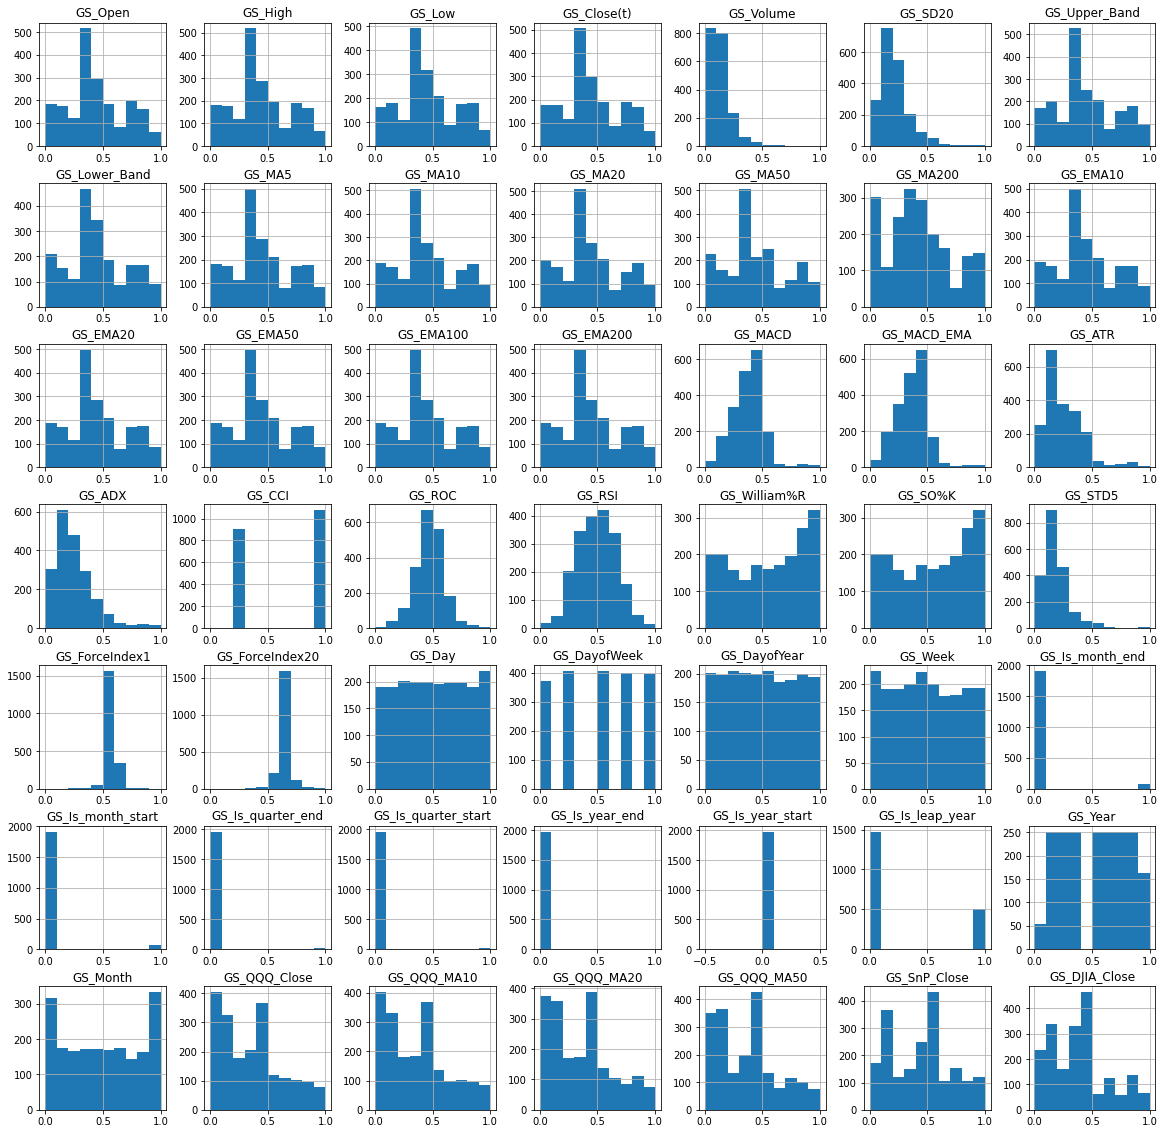

In [24]:
train_copy.filter(like="GS").hist(figsize=(20, 20));

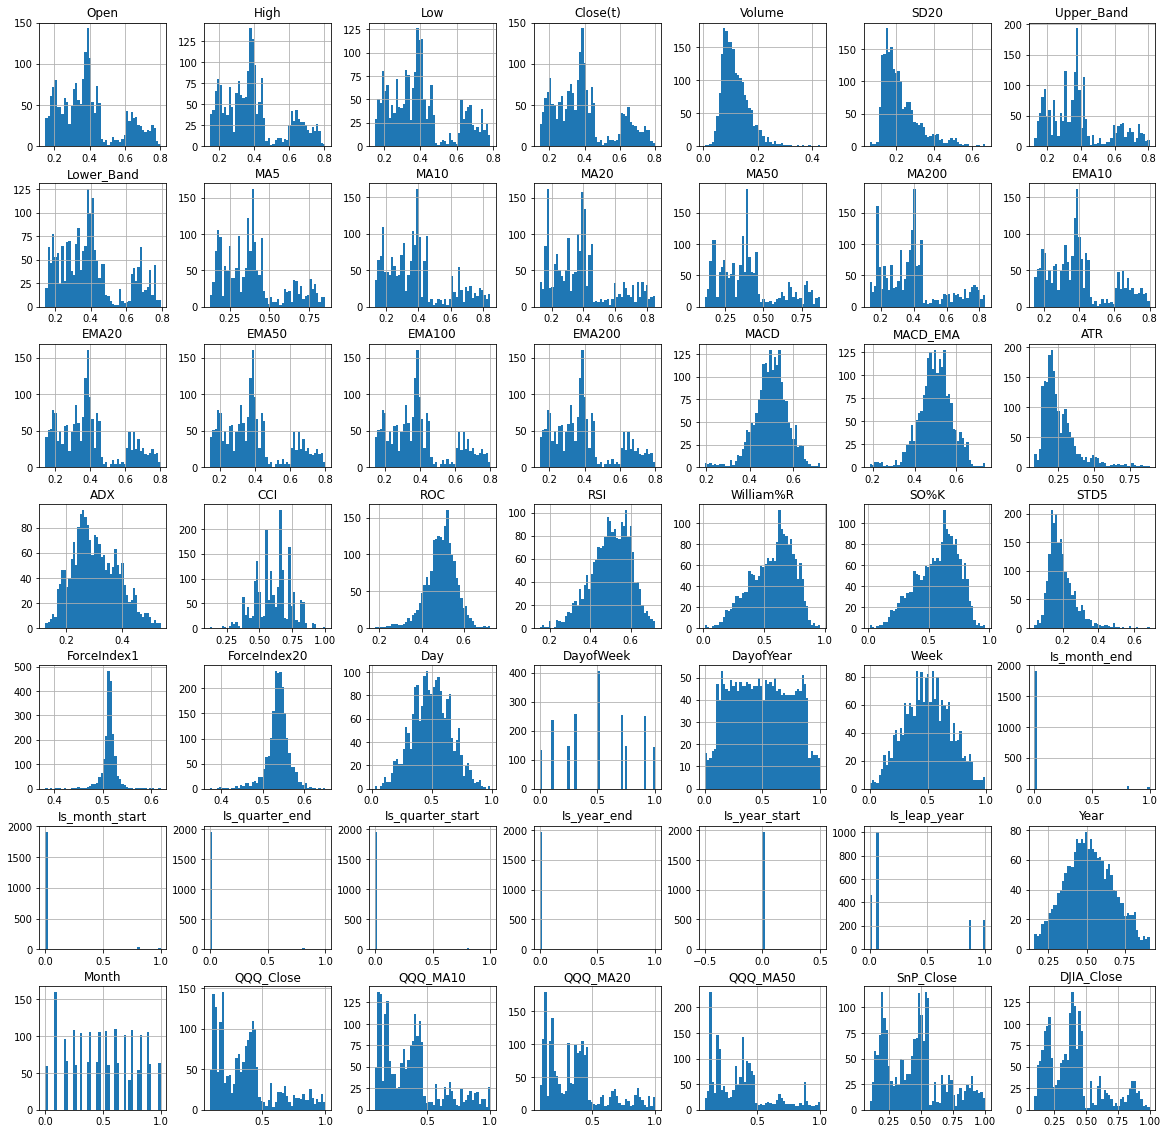

In [25]:
explore_data.hist(figsize=(20, 20), bins=50);

<AxesSubplot:>

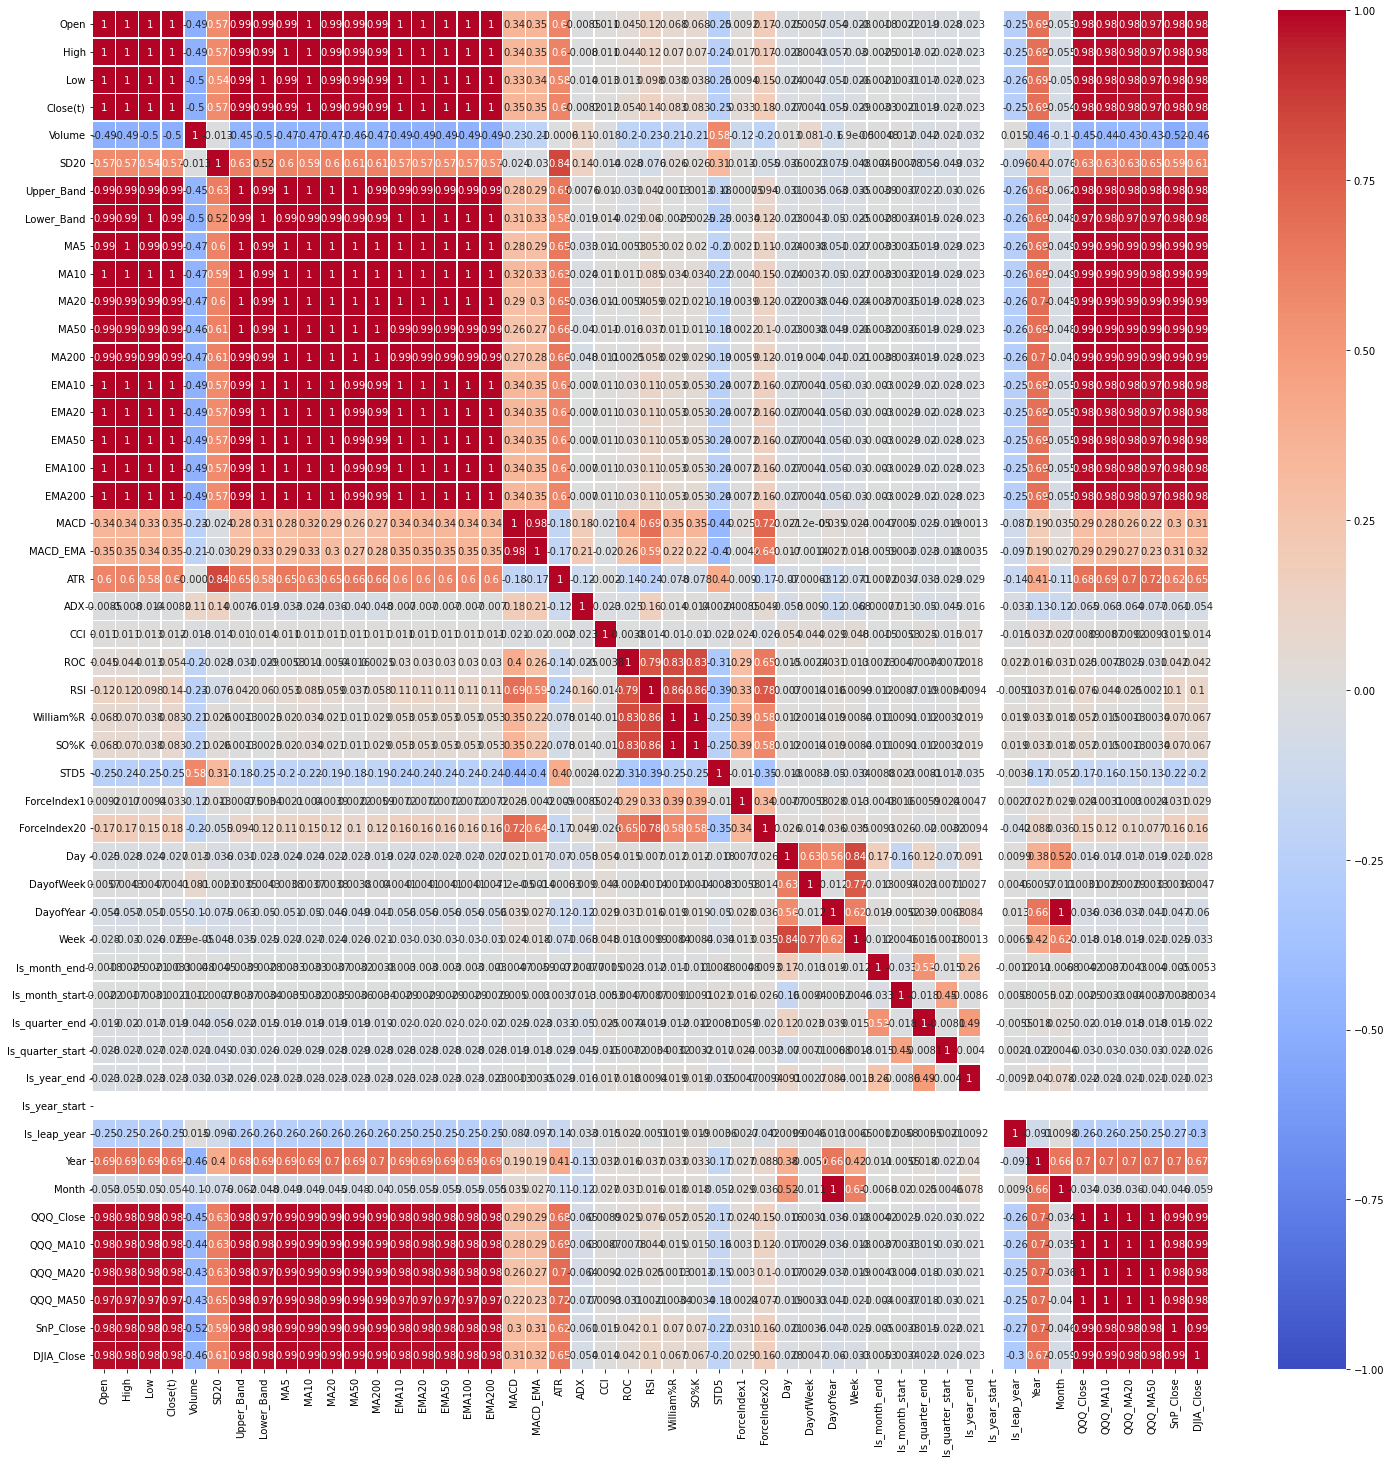

In [26]:
# sns heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(explore_data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', linewidths=0.5)

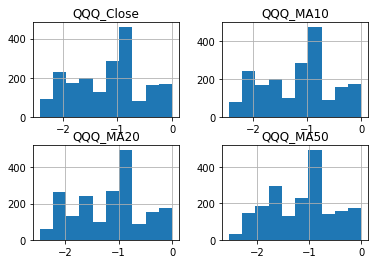

In [27]:
np.log(explore_data.filter(like='QQQ')).hist();

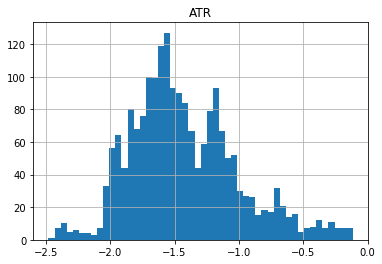

In [28]:
np.log(explore_data.filter(like='ATR')).hist(bins=50);

array([[<AxesSubplot:title={'center':'DJIA_Close'}>]], dtype=object)

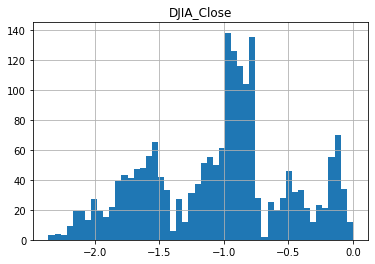

In [29]:
np.log(explore_data.filter(like="DJIA")).hist(bins=50)

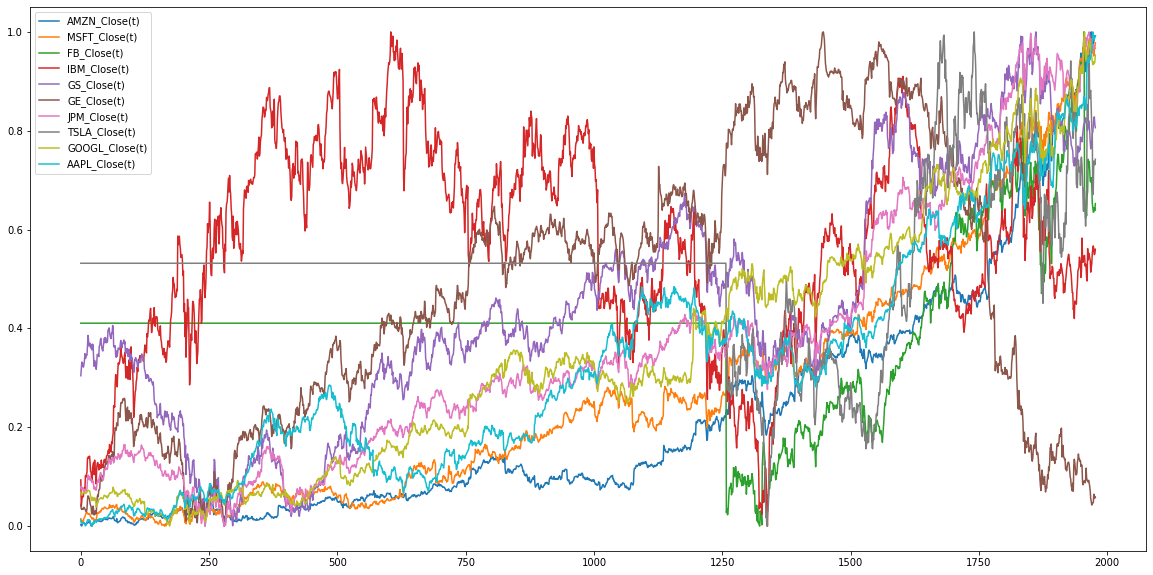

In [30]:
train_copy.filter(like="Close(t)").plot(figsize=(20, 10));

Prepare the data
----

In [7]:
# transformers and functions
class DropColumnsContainingNATransformer(BaseEstimator, TransformerMixin):
    """
    This class drops any columns that contain any NANs
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=X.isna().sum()[X.isna().sum() > 0].index)

class ColumnsLikeFunctionTransformer(BaseEstimator, TransformerMixin):
    """
    This class acts like a function transform but only on the specified columns
    """
    def __init__(self, func_to_apply, cols_like=None):
        """
        Parameters
        ----------
        func_to_apply : function (or strings 'drop', )
        cols_like : lst of strs
        """
        self.func_to_apply = func_to_apply
        self.cols_like = cols_like
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.func_to_apply == 'drop':
            return X.drop(columns=self.get_cols_like(X))
        else:
            func_transformer = FunctionTransformer(self.func_to_apply)
            cols_to_transform = self.get_cols_like(X)
            # get other columns in X that are not in cols_to_transform
            cols_not_to_transform = [col for col in X.columns if col not in cols_to_transform]
            return func_transformer.fit_transform(X[cols_to_transform]).join(X[cols_not_to_transform])

    def get_cols_like(self, X):
        """
        This function returns a list of columns that contain the string
        @param df: the dataframe to search
        @param cols_like: the string to search for
        """
        if self.cols_like is None:
            return []
        return [x for col in self.cols_like for x in X.filter(like=col).columns]


class MinMaxIgnoreNonNumericScaler(BaseEstimator, TransformerMixin):
    """
    This class has a MinMaxScaler, but only attempts to use it on the numeric columns and will 
    combine everything back into a dataframe afterwards
    """
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        numeric_cols = list(X.select_dtypes(include=['number']).columns)
        # remove all elements that contain `Close(t)`
        numeric_cols = [col for col in numeric_cols if 'Close(t)' not in col]
        return pd.DataFrame(
            MinMaxScaler().fit_transform(X[numeric_cols]), 
            columns=numeric_cols, index=X.index
            ).join(X.select_dtypes(include=['string'])).join(X.filter(like='Close(t)'))

class DropRowsOverPercentageTransformer(BaseEstimator, TransformerMixin):
    """
    This class drops rows that have above a threshold of nans
    """
    def __init__(self, percentage):
        self.percentage = percentage
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nan_counts = X.isna().sum(axis=1)
        return X.drop(index=nan_counts[nan_counts > X.shape[0] * self.percentage].index)

class NumpyArrayToPandasDataFrame(BaseEstimator, TransformerMixin):
    """
    This class takes a numpy array and transforms
    it back into a pandas dataframe during within a pipeline.

    CREDIT: Nik Kovacs. We didn't write this function!
    """
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X):
        self.indexes = X.index
        self.columns = X.columns
        X_new = self.transformer.transform(X)

        if not isinstance(X_new, pd.DataFrame):    
            return pd.DataFrame(X_new, index=self.indexes[:X.shape[0]], columns=self.columns[:X.shape[1]])
        return X_new

class AddXLagsToSamplesTransformer(BaseEstimator, TransformerMixin):
    """
    This class adds lags to the samples
    """
    def __init__(self, lags):
        self.lags = lags
    
    def fit(self, X, y=None):
        self.prefixes_ = list(dict.fromkeys([x.split("_")[0] for x in X.columns]))
        self.column_suffixes_ = set(["_".join(x.split("_")[1:]) for x in X.columns])
        return self
    
    def transform(self, X):
        # all combinations of prefixes and column_suffixes
        dataframes = [X]
        for i in range(self.lags):
            curr_cols = [x + "_" + y + f'_lag({-(i+1)})' for x in self.prefixes_ for y in self.column_suffixes_]
            for col in curr_cols:
                dataframes.append(pd.DataFrame({col: X["_".join(col.split("_")[:-1])].shift(-(i+1))}))
        return pd.concat(dataframes, axis=1)[30:]

                
        

In [8]:
preprocessor = Pipeline(steps=[
    # ('drop_col_with_na', DropColumnsContainingNATransformer()),
    # ('drop_rows_with_na_over_percentage', DropRowsOverPercentageTransformer(0.15)),
    ('drop_cols_like', ColumnsLikeFunctionTransformer(func_to_apply='drop', cols_like=["_S_Close(t-", "_S_Open(t-1", "QQQ(t-", "SnP(t-", "DJIA(t-", "_Close_forcast", "_Date_col", "Year", "Month", "Week"])),
    ('imputer', NumpyArrayToPandasDataFrame(SimpleImputer(strategy='median'))),
    # ('quantile_transformer', NumpyArrayToPandasDataFrame(QuantileTransformer(output_distribution='uniform'))),
    ('scale', MinMaxIgnoreNonNumericScaler()),
    ('log_cols_like', ColumnsLikeFunctionTransformer(func_to_apply=np.log1p, cols_like=["QQQ", "Open", "_EMA", "Volume", "STD5", "ATR"])),
])
    

In [9]:
rnn_preprocessor = Pipeline(steps=[
    ('base_preprocessor', preprocessor),
    ('add_lags', AddXLagsToSamplesTransformer(lags=30)),
])

Short-List Promising Models
----

##### SKForecast ForecasterAutoRegMultiOutput

In [10]:
class ForecasterMultiInputWrapper():
    """
    This class wraps the forecaster and creates multiple instances for multiple different inputs.
    """
    def __init__(self, preprocessor, forecaster, data, regressor, steps, lags):
        """
        Parameters
        ----------
        preprocessor : Pipeline
        forecaster : skforecast forecaster (Not instantiated)
        data : pd.DataFrame
        regressor : sklearn api-compatible regressor
        steps : int (how many steps into the future to predict)
        lags : int (how many lags to use for the data)
        """
        self.preprocessor = preprocessor
        self.forecaster = forecaster
        self.data = preprocessor.fit_transform(data)
        self.regressor = regressor
        self.steps = steps
        self.lags = lags
        self.forecasters = []

        def __num_unique_prefixes():
            self.prefixes_ = [x.split("_")[0] for x in self.data.columns]
            self.prefixes_ = list(dict.fromkeys(self.prefixes_))            
            return len(set(self.prefixes_))

        for _ in range(__num_unique_prefixes()):
            self.forecasters.append(self.forecaster(regressor=self.regressor, steps=self.steps, lags=self.lags))
    
    def fit(self, y_cols_like=None):
        y_cols = self.data.filter(like=y_cols_like).columns
        self.exogs_cols_ = []
        for i, forecaster in enumerate(self.forecasters):
            self.exogs_cols_.append([x for x in self.data.filter(like=self.prefixes_[i]).columns if x != y_cols[i]])
            forecaster.fit(y=self.data[y_cols[i]], exog=self.data[self.exogs_cols_[i]])
        return self

    def predict(self, steps=None):
        self.preds_ = []
        for i, forecaster in enumerate(self.forecasters):
            self.preds_.append(forecaster.predict(exog=self.data[self.exogs_cols_[i]], steps=steps))
        return {self.prefixes_[i]: self.preds_[i] for i in range(len(self.forecasters))}
        
    
    

In [11]:
forecaster = ForecasterMultiInputWrapper(
    preprocessor=preprocessor,
    forecaster=ForecasterAutoregMultiOutput,
    regressor=RandomForestRegressor(n_estimators=300, max_depth=100, max_leaf_nodes=75, n_jobs=-1),
    lags=30,
    steps=7,
    data=train.copy(deep=True)
)

In [337]:
forecaster.fit(y_cols_like="Close(t)")

In [338]:
preds = forecaster.predict()

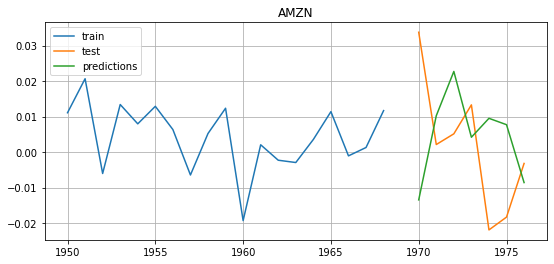

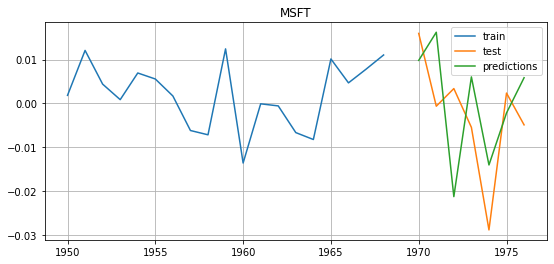

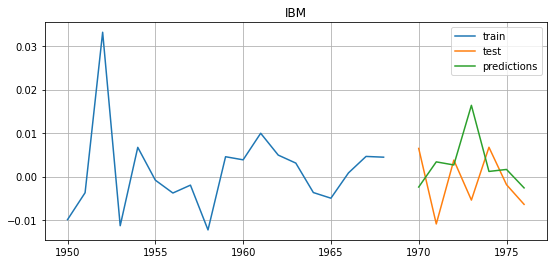

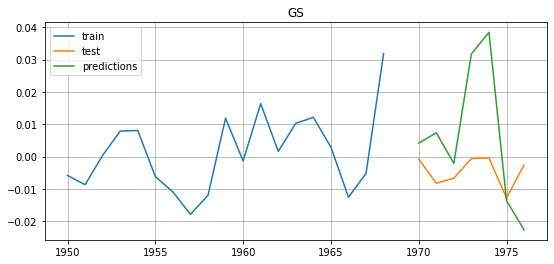

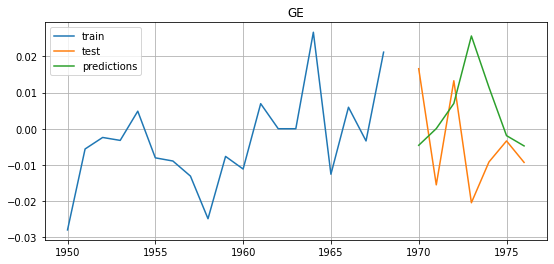

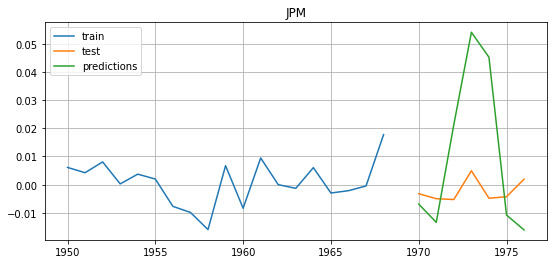

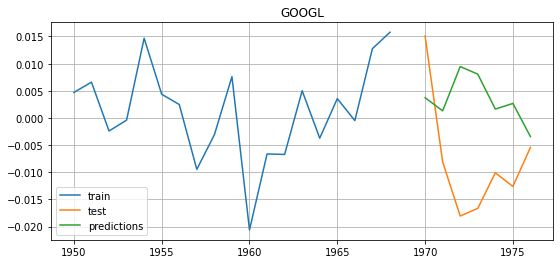

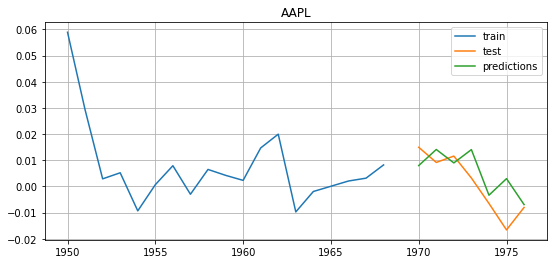

In [339]:
for prefix in forecaster.prefixes_:
    fig, ax = plt.subplots(figsize=(9, 4))
    train[f'{prefix}_Close(t)'][-20:-1].plot(ax=ax, label='train')
    validation[f'{prefix}_Close(t)'].plot(ax=ax, label='test')
    preds[f"{prefix}"].plot(ax=ax, label='predictions')
    plt.title(f"{prefix}")
    ax.grid()
    ax.legend();

##### tf.keras Recurrent Neural Network

In [10]:
# Have to reorganize the data for the network because the inputs need to be formatted differently.
def load_data_for_keras():
    data = load_data()
    # split off all columns names containing the string 'Close(t)'
    Y = data.filter(like='Close(t)')
    X = data.drop(columns=[x for x in data.columns if 'Close(t)' in x])
    X = rnn_preprocessor.fit_transform(X)
    # make y have also have the next 6 targets in order
    col_prefixes = [x.split('_')[0] for x in list(Y.columns)]
    for k in range(len(col_prefixes)):
        for i in range(7):
            Y[f'{col_prefixes[k]}_Close(t+{i+1})'] = Y[f'{col_prefixes[k]}_Close(t)'].shift(-(i+1))
    # sort X and Y by column names
    X = X.reindex(sorted(X.columns), axis=1)
    Y = Y.reindex(sorted(Y.columns), axis=1)
    Y.drop(columns=Y.filter(like="_Close(t)").columns, inplace=True)

    X_train, X_valid, X_test = X[:int(X.shape[0] * 0.8)], X[int(X.shape[0] * 0.8):int(X.shape[0] * 0.9)], X[int(X.shape[0] * 0.9):]
    Y_train, Y_valid, Y_test = Y[:int(Y.shape[0] * 0.8)], Y[int(Y.shape[0] * 0.8):int(Y.shape[0] * 0.9)], Y[int(Y.shape[0] * 0.9):]

    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [11]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_data_for_keras()

/tmp/ipykernel_4098534/2134097487.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[f'{col_prefixes[k]}_Close(t+{i+1})'] = Y[f'{col_prefixes[k]}_Close(t)'].shift(-(i+1))


In [17]:
X_train.shape, Y_train.shape

((3958, 13330), (3982, 70))

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='causal', activation="relu", input_shape=[None, 1], name="conv1"))
model.add(keras.layers.BatchNormalization(name="bn1"))
model.add(keras.layers.Conv1D(64, kernel_size=5, strides=2, padding='causal', activation="relu", name="conv2"))
model.add(keras.layers.BatchNormalization(name="bn2"))
model.add(keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='causal', activation="relu", name="conv3"))
model.add(keras.layers.BatchNormalization(name="bn3"))
model.add(keras.layers.GRU(128, return_sequences=True, name="gru1"))
model.add(keras.layers.GRU(128, name="gru2"))
model.add(keras.layers.Dense(Y_train.shape[1], name="output"))

In [46]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="MAE", optimizer=optimizer)

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

In [23]:
preds = model.predict(X_valid)

In [24]:
Y_valid

,AAPL_Close(t+1),AAPL_Close(t+2),AAPL_Close(t+3),AAPL_Close(t+4),AAPL_Close(t+5),AAPL_Close(t+6),AAPL_Close(t+7),AMZN_Close(t+1),AMZN_Close(t+2),AMZN_Close(t+3),AMZN_Close(t+4),AMZN_Close(t+5),AMZN_Close(t+6),AMZN_Close(t+7),FB_Close(t+1),FB_Close(t+2),FB_Close(t+3),FB_Close(t+4),FB_Close(t+5),FB_Close(t+6),FB_Close(t+7),GE_Close(t+1),GE_Close(t+2),GE_Close(t+3),GE_Close(t+4),GE_Close(t+5),GE_Close(t+6),GE_Close(t+7),GOOGL_Close(t+1),GOOGL_Close(t+2),GOOGL_Close(t+3),GOOGL_Close(t+4),GOOGL_Close(t+5),GOOGL_Close(t+6),GOOGL_Close(t+7),GS_Close(t+1),GS_Close(t+2),GS_Close(t+3),GS_Close(t+4),GS_Close(t+5),GS_Close(t+6),GS_Close(t+7),IBM_Close(t+1),IBM_Close(t+2),IBM_Close(t+3),IBM_Close(t+4),IBM_Close(t+5),IBM_Close(t+6),IBM_Close(t+7),JPM_Close(t+1),JPM_Close(t+2),JPM_Close(t+3),JPM_Close(t+4),JPM_Close(t+5),JPM_Close(t+6),JPM_Close(t+7),MSFT_Close(t+1),MSFT_Close(t+2),MSFT_Close(t+3),MSFT_Close(t+4),MSFT_Close(t+5),MSFT_Close(t+6),MSFT_Close(t+7),TSLA_Close(t+1),TSLA_Close(t+2),TSLA_Close(t+3),TSLA_Close(t+4),TSLA_Close(t+5),TSLA_Close(t+6),TSLA_Close(t+7)
3978,0.719760,0.778771,0.346144,0.722736,0.049002,0.068453,0.919406,0.762530,0.768907,0.951818,0.152885,0.223673,0.020755,0.911941,0.115638,0.890870,0.985726,0.935050,0.066644,0.016471,0.948236,0.470457,0.605507,0.268383,0.520599,0.481487,0.052845,0.824038,0.702724,0.802575,0.896995,0.310318,0.175178,0.065504,0.887564,0.252656,0.699434,0.631948,0.658671,0.825516,0.099242,0.864462,0.640314,0.490938,0.673344,0.762150,0.091205,0.062447,0.903869,0.355464,0.621785,0.463836,0.355310,0.532694,0.245889,0.673112,0.671790,0.653223,0.323971,0.637650,0.251232,0.049991,0.897799,0.008822,0.058308,0.956836,0.090351,0.044051,0.059190,0.944794
3979,0.778771,0.346144,0.722736,0.049002,0.068453,0.919406,0.927293,0.768907,0.951818,0.152885,0.223673,0.020755,0.911941,0.078609,0.890870,0.985726,0.935050,0.066644,0.016471,0.948236,0.042038,0.605507,0.268383,0.520599,0.481487,0.052845,0.824038,0.096718,0.802575,0.896995,0.310318,0.175178,0.065504,0.887564,0.102373,0.699434,0.631948,0.658671,0.825516,0.099242,0.864462,0.064770,0.490938,0.673344,0.762150,0.091205,0.062447,0.903869,0.096476,0.621785,0.463836,0.355310,0.532694,0.245889,0.673112,0.266286,0.653223,0.323971,0.637650,0.251232,0.049991,0.897799,0.151070,0.058308,0.956836,0.090351,0.044051,0.059190,0.944794,0.068745
3980,0.346144,0.722736,0.049002,0.068453,0.919406,0.927293,0.968096,0.951818,0.152885,0.223673,0.020755,0.911941,0.078609,0.232808,0.985726,0.935050,0.066644,0.016471,0.948236,0.042038,0.903757,0.268383,0.520599,0.481487,0.052845,0.824038,0.096718,0.341751,0.896995,0.310318,0.175178,0.065504,0.887564,0.102373,0.705948,0.631948,0.658671,0.825516,0.099242,0.864462,0.064770,0.261984,0.673344,0.762150,0.091205,0.062447,0.903869,0.096476,0.153094,0.463836,0.355310,0.532694,0.245889,0.673112,0.266286,0.424218,0.323971,0.637650,0.251232,0.049991,0.897799,0.151070,0.236238,0.956836,0.090351,0.044051,0.059190,0.944794,0.068745,0.882896
3981,0.722736,0.049002,0.068453,0.919406,0.927293,0.968096,0.964687,0.152885,0.223673,0.020755,0.911941,0.078609,0.232808,0.874996,0.935050,0.066644,0.016471,0.948236,0.042038,0.903757,0.905246,0.520599,0.481487,0.052845,0.824038,0.096718,0.341751,0.774413,0.310318,0.175178,0.065504,0.887564,0.102373,0.705948,0.892988,0.658671,0.825516,0.099242,0.864462,0.064770,0.261984,0.823160,0.762150,0.091205,0.062447,0.903869,0.096476,0.153094,0.816450,0.355310,0.532694,0.245889,0.673112,0.266286,0.424218,0.608524,0.637650,0.251232,0.049991,0.897799,0.151070,0.236238,0.910897,0.090351,0.044051,0.059190,0.944794,0.068745,0.882896,0.946922
3982,0.049002,0.068453,0.919406,0.927293,0.968096,0.964687,0.233261,0.223673,0.020755,0.911941,0.078609,0.232808,0.874996,0.876125,0.066644,0.016471,0.948236,0.042038,0.903757,0.905246,0.912421,0.481487,0.052845,0.824038,0.096718,0.341751,0.774413,0.432055,0.175178,0.065504,0.887564,0.102373,0.705948,0.892988,0.216910,0.825516,0.099242,0.864462,0.064770,0.261984,0.823160,0.149483,0.091

In [25]:
preds.shape

(497, 70)

In [26]:
prefixes_in_order = list(dict.fromkeys([x.split("_")[0] for x in Y_valid.columns]))

In [27]:
# align indexes of preds and Y_valid
Y_valid.reset_index(drop=True, inplace=True)

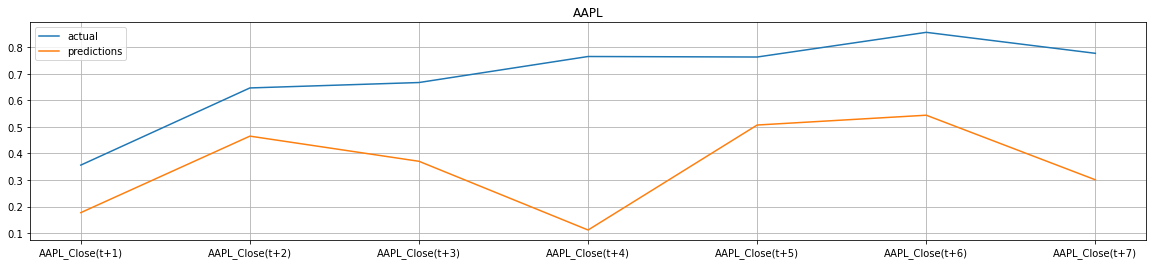

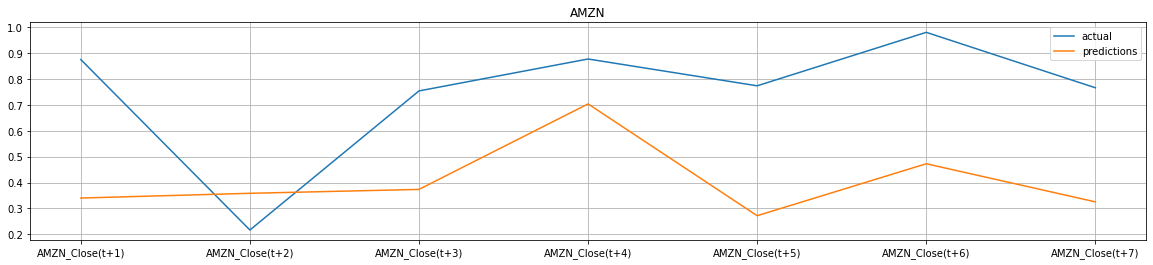

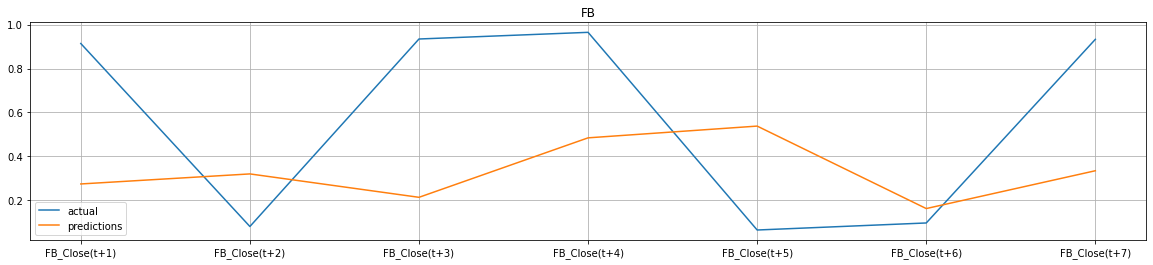

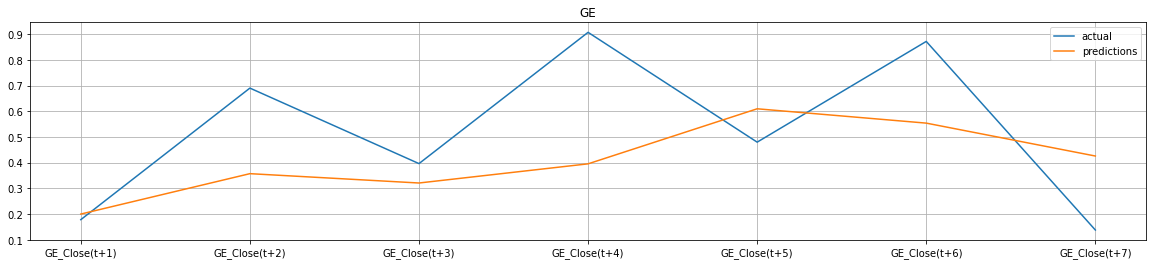

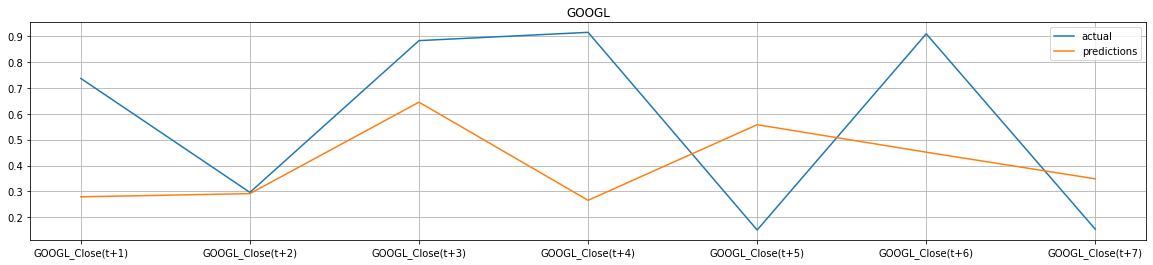

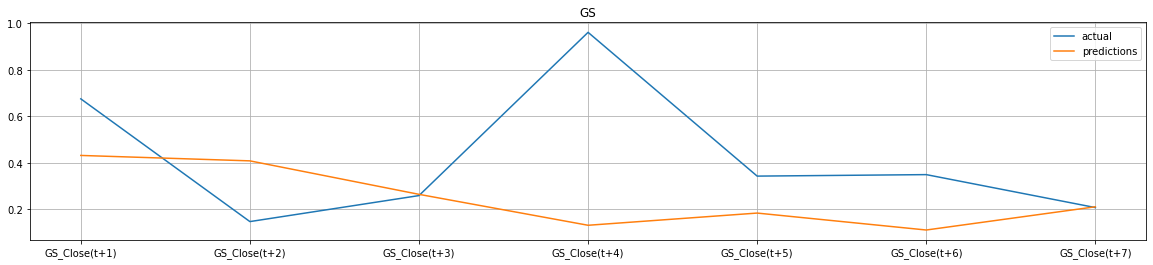

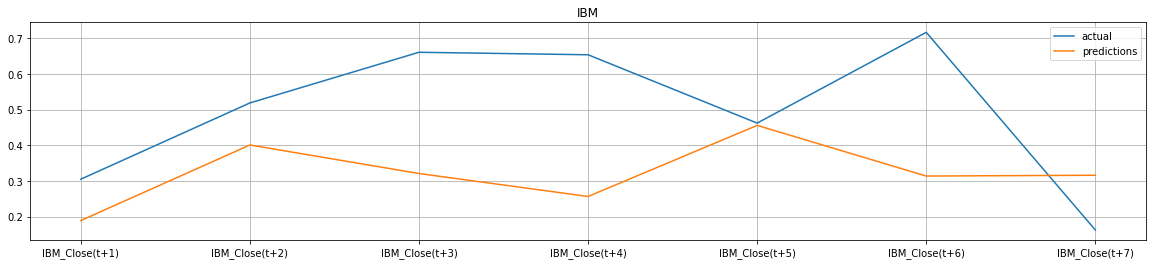

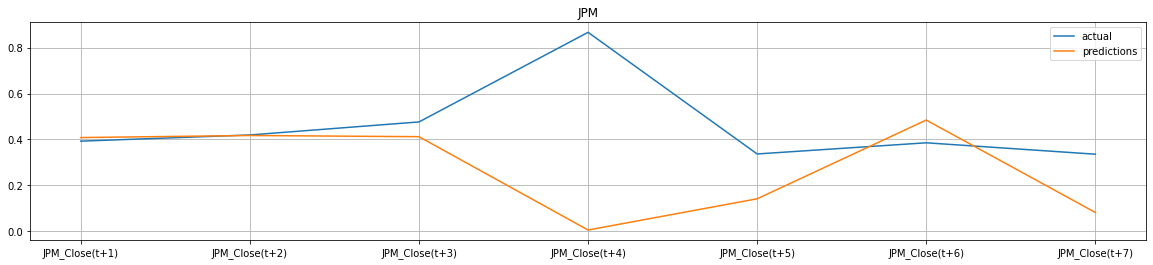

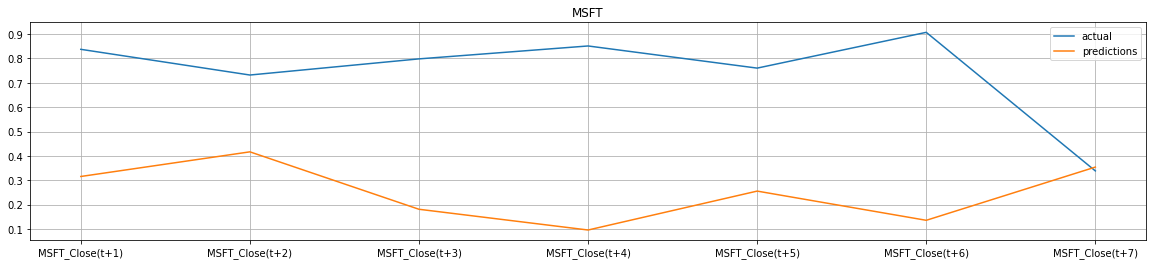

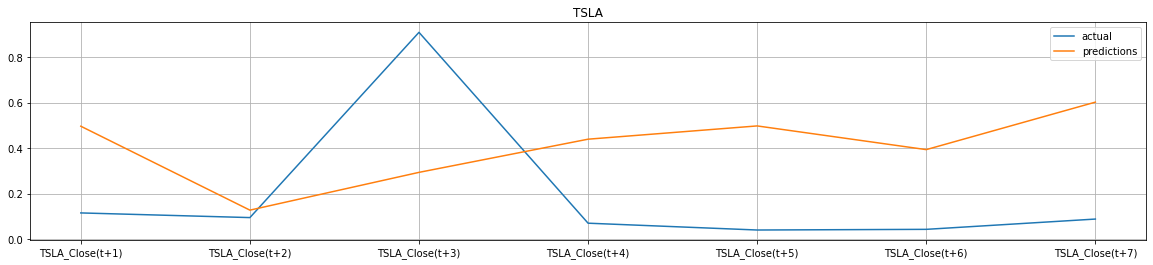

In [28]:
# plot APPL
for i, j in enumerate(range(0, len(prefixes_in_order) * 7, 7)):
    fig, ax = plt.subplots(figsize=(20, 4))
    Y_valid.filter(like=prefixes_in_order[i]).iloc[-1].plot(ax=ax, label='actual')
    preds_temp = pd.DataFrame(preds[:,j:j+7]).iloc[-1]
    preds_temp.plot(ax=ax, label='predictions')
    plt.title(f"{prefixes_in_order[i]}")
    ax.grid()
    ax.legend();


Fine Tune the Model
----

In [59]:
# modified
def load_data_for_keras_modified():
    data = load_data()
    # split off all columns names containing the string 'Close(t)'
    # drop all TSLA and FB cols
    data.drop(columns=data.filter(like="TSLA").columns, inplace=True)
    data.drop(columns=data.filter(like="FB").columns, inplace=True)

    # drop any samples containing NaN
    data = data.dropna()

    # drop all columns containing the string `Date`
    data.drop(columns=data.filter(like="Date").columns, inplace=True)

    Y = data.filter(like='Close(t)')
    X = data.drop(columns=[x for x in data.columns if 'Close(t)' in x])
    X = AddXLagsToSamplesTransformer(lags=30).fit_transform(X)
    Y = Y[30:] # because ^ loses the first 30
    # make y have also have the next 6 targets in order
    col_prefixes = [x.split('_')[0] for x in list(Y.columns)]
    for k in range(len(col_prefixes)):
        for i in range(7):
            Y[f'{col_prefixes[k]}_Close(t+{i+1})'] = Y[f'{col_prefixes[k]}_Close(t)'].shift(-(i+1))
    # sort X and Y by column names
    X = X.reindex(sorted(X.columns), axis=1)
    Y = Y.reindex(sorted(Y.columns), axis=1)
    Y.drop(columns=Y.filter(like="_Close(t)").columns, inplace=True)

    X_train, X_valid, X_test = X[:int(X.shape[0] * 0.8)], X[int(X.shape[0] * 0.8):int(X.shape[0] * 0.9)], X[int(X.shape[0] * 0.9):]
    Y_train, Y_valid, Y_test = Y[:int(Y.shape[0] * 0.8)], Y[int(Y.shape[0] * 0.8):int(Y.shape[0] * 0.9)], Y[int(Y.shape[0] * 0.9):]

    X_test = X_test[:-30]
    Y_test = Y_test[:-30]

    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [60]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_data_for_keras_modified()

In [12]:
def build_model(GRU_units=128, output=56, dropout=0.2, optimizer=None):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='causal', activation="relu", input_shape=[None, 1], name="conv1"))
    model.add(keras.layers.BatchNormalization(name="bn1"))
    model.add(keras.layers.Conv1D(64, kernel_size=5, strides=2, padding='causal', activation="relu", name="conv2"))
    model.add(keras.layers.BatchNormalization(name="bn2"))
    model.add(keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='causal', activation="relu", name="conv3"))
    model.add(keras.layers.BatchNormalization(name="bn3"))
    model.add(keras.layers.GRU(GRU_units, return_sequences=True, name="gru1"))
    model.add(keras.layers.Dropout(rate=dropout, name="dropout1"))
    model.add(keras.layers.GRU(GRU_units, name="gru2"))
    model.add(keras.layers.Dropout(rate=dropout, name="dropout2"))
    model.add(keras.layers.Dense(output, name="output"))

    if optimizer is None:
        optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        
    model.compile(loss="MAE", optimizer=optimizer)
    return model


In [13]:
keras_model = KerasRegressor(
    build_model
)

In [14]:
keras_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [23]:
param_grid = [
    {
        "model__GRU_units": [128, 256],
        "model__dropout": [0.2, 0.3],
        "batch_size": [32, 64],
        "model__optimizer": [
            keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
            ],
    }
]

In [24]:
search = RandomizedSearchCV(param_distributions=param_grid, estimator=keras_model, cv=2, verbose=1)

In [47]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
            keras.callbacks.ModelCheckpoint("./fit_model.h5", save_best_only=True),
        ]

In [26]:
search.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), callbacks=callbacks, epochs=10)

/refactored-robot/lib64/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/10
31/31 [==============================] - 66s 2s/step - loss: 0.0155 - val_loss: 0.0150
Epoch 2/10
31/31 [==============================] - 58s 2s/step - loss: 0.0115 - val_loss: 0.0150
Epoch 3/10
31/31 [==============================] - 58s 2s/step - loss: 0.0108 - val_loss: 0.0149
Epoch 4/10
31/31 [==============================] - 58s 2s/step - loss: 0.0106 - val_loss: 0.0152
Epoch 5/10
31/31 [==============================] - 59s 2s/step - loss: 0.0104 - val_loss: 0.0151
Epoch 6/10
31/31 [==============================] - 58s 2s/step - loss: 0.0104 - val_loss: 0.0152
Epoch 7/10
31/31 [==============================] - 58s 2s/step - loss: 0.0103 - val_loss: 0.0149
Epoch 8/10
31/31 [==============================] - 58s 2s/step - loss: 0.0102 - val_loss: 0.0149
Epoch 9/10
31/31 [==============================] - 59s 2s/step - loss: 0.0102 - val_loss: 0.0156
Epoch 10/10
31/31 [==============================] - 10s 2

RandomizedSearchCV(cv=2,
                   estimator=KerasRegressor(model=<function build_model at 0x7f62817cef70>),
                   param_distributions=[{'batch_size': [32, 64],
                                         'model__GRU_units': [128, 256],
                                         'model__dropout': [0.2, 0.3],
                                         'model__optimizer': [<keras.optimizer_v2.nadam.Nadam object at 0x7f62181f0fd0>]}],
                   verbose=1)

In [36]:
search.best_params_

{'model__optimizer': <keras.optimizer_v2.nadam.Nadam at 0x7f62181f0fd0>,
 'model__dropout': 0.3,
 'model__GRU_units': 256,
 'batch_size': 32}

In [45]:
search.best_score_

-0.10270926472660881

In [41]:
# save best estimator
best_model = search.best_estimator_.model_

In [42]:
# save best model
best_model.save("./best_model.h5")

In [48]:
# load best_model.h5
best_model = keras.models.load_model("./best_model.h5")

In [49]:
history = best_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=300, callbacks=callbacks)

Epoch 1/300
62/62 [==============================] - 574s 9s/step - loss: 0.0109 - val_loss: 0.0230
Epoch 2/300
62/62 [==============================] - 443s 7s/step - loss: 0.0109 - val_loss: 0.0163
Epoch 3/300
62/62 [==============================] - 216s 3s/step - loss: 0.0109 - val_loss: 0.0159
Epoch 4/300
62/62 [==============================] - 178s 3s/step - loss: 0.0109 - val_loss: 0.0196
Epoch 5/300
62/62 [==============================] - 175s 3s/step - loss: 0.0108 - val_loss: 0.0163
Epoch 6/300
62/62 [==============================] - 177s 3s/step - loss: 0.0108 - val_loss: 0.0152
Epoch 7/300
62/62 [==============================] - 178s 3s/step - loss: 0.0108 - val_loss: 0.0164
Epoch 8/300
62/62 [==============================] - 183s 3s/step - loss: 0.0108 - val_loss: 0.0158
Epoch 9/300
62/62 [==============================] - 189s 3s/step - loss: 0.0108 - val_loss: 0.0152
Epoch 10/300
62/62 [==============================] - 192s 3s/step - loss: 0.0108 - val_loss: 0.0143

In [52]:
best_model.evaluate(X_train, Y_train)

62/62 [==============================] - 126s 2s/step - loss: 0.0112


0.011197383515536785

In [53]:
best_model.evaluate(X_valid, Y_valid)

8/8 [==============================] - 17s 2s/step - loss: 0.0143


0.014289641752839088

In [61]:
best_model.evaluate(X_test, Y_test)

7/7 [==============================] - 15s 2s/step - loss: 0.0191


0.019146962091326714

In [66]:
preds = best_model.predict(X_test)

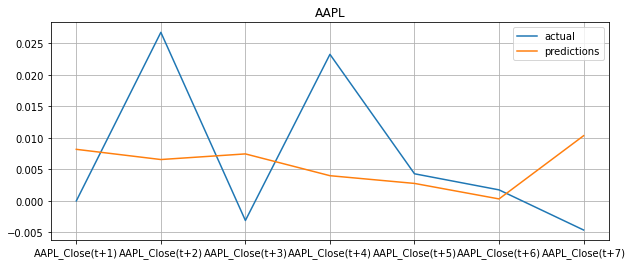

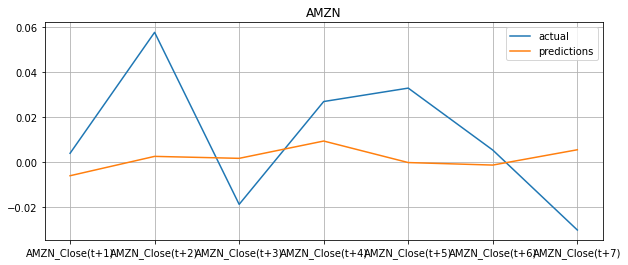

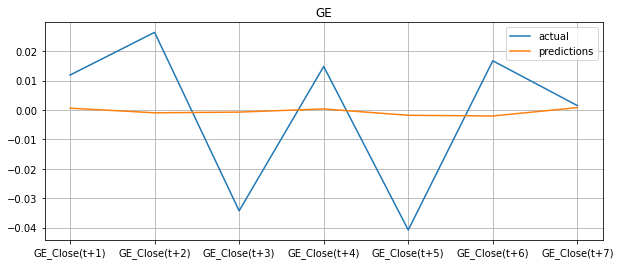

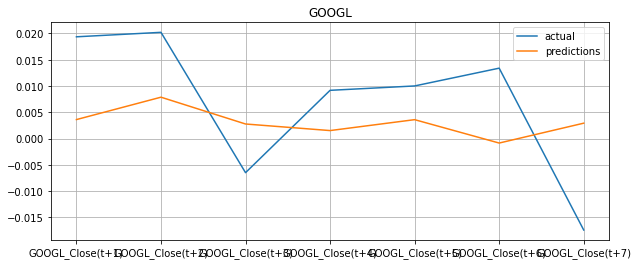

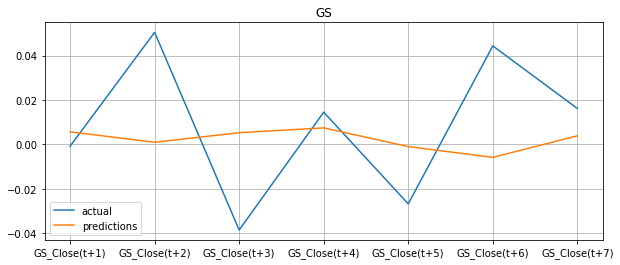

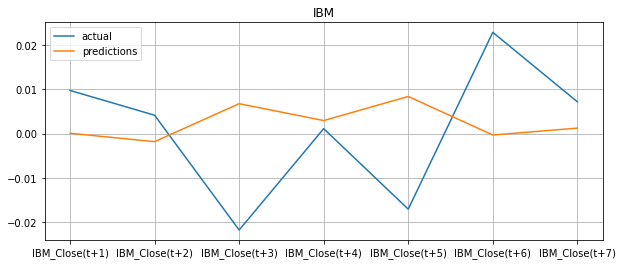

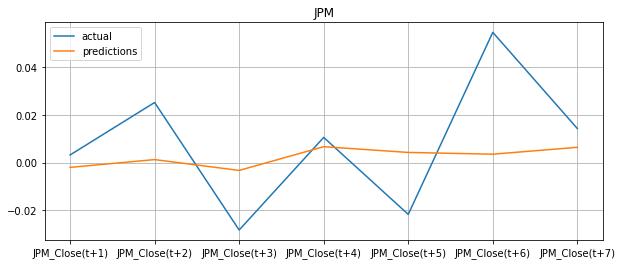

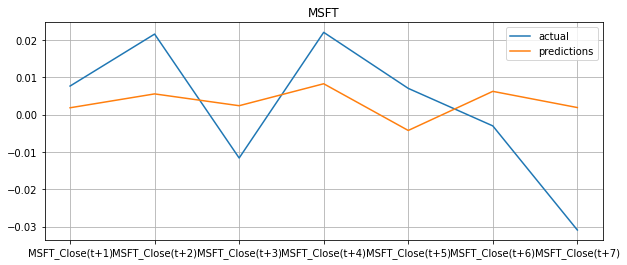

In [72]:
prefixes_in_order = list(dict.fromkeys([x.split("_")[0] for x in Y_test.columns]))
for i, j in enumerate(range(0, len(prefixes_in_order) * 7, 7)):
    fig, ax = plt.subplots(figsize=(10, 4))
    Y_test.filter(like=prefixes_in_order[i]).iloc[-1].plot(ax=ax, label='actual')
    preds_temp = pd.DataFrame(preds[:,j:j+7]).iloc[-1]
    preds_temp.plot(ax=ax, label='predictions')
    plt.title(f"{prefixes_in_order[i]}")
    ax.grid()
    ax.legend();

Present the Solution
----